In [49]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib ipympl


In [50]:
def calculate_mdx_mdy(x1, y1, z1, u1, v1, z2):
    
    # Calculate derivatives 
    d_x1 = d_y1 = z1 / 1000
    
    # Direction vectors of derivative ray
    d_vx_pp1 = u1 - (x1 + d_x1)
    d_vy_pp1 = v1 - (y1 + d_y1)
    vz_pp1 = 0.0 - z1
    d_v_mag = np.sqrt(d_vx_pp1**2 + d_vy_pp1**2 + vz_pp1**2)
    
    # And direction cosines
    d_M1_p = d_vy_pp1 / d_v_mag 
    d_L1_p = d_vx_pp1 / d_v_mag

    d_x2 = z2 * d_L1_p
    d_y2 = z2 * d_M1_p
    
    # To obtain derivative in magnification - which I don't know at all if it is correct. 
    mdx = d_x2 / (x1 + d_x1)
    mdy = d_y2 / (y1 + d_y1)
    
    return mdx, mdy

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N
    
    


In [51]:
def fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If we want a lens that sends parallel rays to a focal plane perfectly, than we have to 
    # set the object distance z1 to an arbitrarily large, but not infinite value, and 
    # define a new small magnification value
    if np.abs(m_p) < 1e-10:
        y1_old = y1
        z1 = -1e10
        m_p = z2 / z1
        L1_p, M1_p, N1_p = calculate_principal_direction_cosines(x1, y1, z1)
        L1, M1, N1  = calculate_direction_cosines(x1, y1, z1)
        
    else:
        L1_p, M1_p, N1_p = calculate_principal_direction_cosines(x1, y1, z1)
        
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        
        mdx, mdy = calculate_mdx_mdy(x1, y1, z1, z2)

        # Obtain coordinates in image plane
        x2 = z2 * L1
        y2 = z2 * M1
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = x2 / rp
        M2_p = y2 / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        
        if fourier_lens:
            L2_p = x1 / z1
            M2_p = y1 / z1
            N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, z2)
            
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1_p + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

In [52]:
def fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1_old = z1
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1_old, principal_plane_x, principal_plane_y, z2)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
        
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p
        y2 = z2 * M1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x)  / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            raise(NotImplementedError)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            
        L2_p = x1 / z1
        M2_p = y1 / z1
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2

    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

In [53]:
def perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p / N1_p
        y2 = z2 * M1_p / N1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x) / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            raise(NotImplementedError)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        a = x1 / z1
        b = y1 / z1
        
        N2_p = np.sqrt(1 - a ** 2 - b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2

    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    return x2, y2, u1, v1, u2, v2
    

Perfect Lens: Infinite Front Conjugate Case

In [59]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -0.5
f = 2

if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(1, 1, N)
z1 = np.linspace(z1, z1, N)

angles = np.linspace(-1, 1, N)

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction 

/tmp/ipykernel_1475288/2382820941.py:57: RuntimeWarning: invalid value encountered in sqrt
  N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)
/tmp/ipykernel_1475288/2658929487.py:61: RuntimeWarning: invalid value encountered in sqrt
  N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)


(-6.45, 3.45, -9.278890982722354, 11.278890982722354)

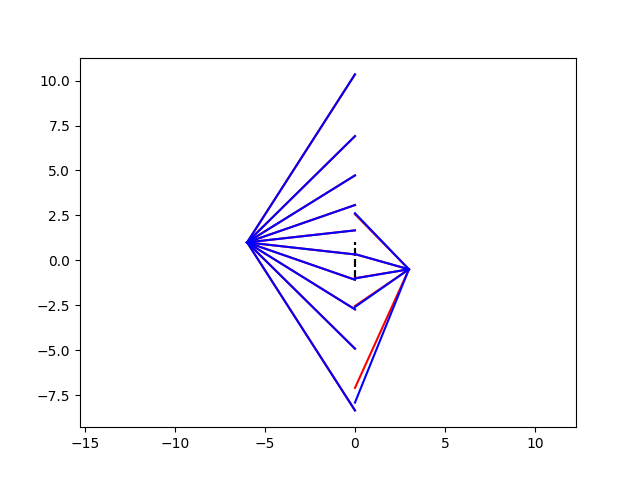

In [61]:
x2, y2, u1, v1, u2, v2 = perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

plt.figure()
plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-r')
plt.plot([], [], '-r', label = 'Perfect Lens')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-r')
plt.axis('equal')

x2, y2, u1, v1, u2, v2 = fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-b')
plt.plot([], [], '-b', label = 'Fourier Lens')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-b')
plt.axis('equal')

In [56]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -1e-11
f = 5

if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(0, 4, N)
z1 = np.linspace(-5, -5, N)

angles = np.linspace(-10, -10, N)

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction 


x2, y2, u1, v1, u2, v2 = perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p)

Perhaps the best thing to do is this much simpler version of the fourier lens, where we basically just use simple sin and tan operations to achieve the same behaviour? It will be faster to calculate. 

-0.47942553825316997 -0.7020660719447847 0.479425538604203 -5e-10


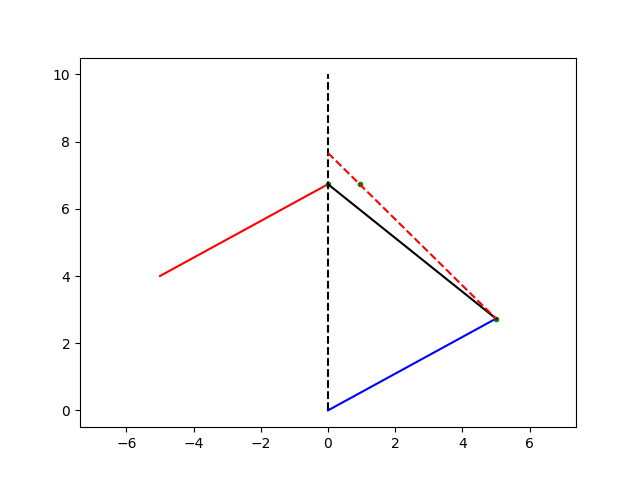

In [57]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = -1e-11
f = 5

if np.abs(m_p) < 1e-10:
    
    z1 = -1e10
    z2 = f
    m_p = z2 / z1
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)


N = 1

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = 4
z1s = z1
z2s = z2

theta = 0.5
angles = theta
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - M1 ** 2) #z direction 
M1_p, N1_p = M1, N1

y2 = z2 * M1_p / N1_p
rp = np.sqrt(y2 **2 + z2 ** 2)
M2_p = y2 / rp
N2_p = np.sqrt(1 - M2_p ** 2)

v1 = - (M1 / N1) * z1s + y1
y2_hat_sin = y2_sin = f * np.sin(theta)
y2_hat_tan = y2_tan = f * np.tan(theta)
zls = lens_z

R2 = np.sqrt(f ** 2 + y2_hat_tan ** 2)
z_circ = -np.sqrt(R2**2 - (v1 - y2_tan) ** 2) + z2

vy_2 = y2_tan - v1
vz_2 = z2 - z_circ
v2_mag = np.sqrt((vy_2) ** 2 + (vz_2) ** 2)
M2 = vy_2 / v2_mag
N2 = vz_2 / v2_mag
v2 = - (M2 / N2) * z2 + y2_tan

Cy = (M2 * m_p) - M1
M2 = (M1 + Cy) / m_p

plt.figure()
plt.plot([z1s, zls], [y1, v1], '-r')
plt.plot([zls, z2s], [np.zeros(y2_tan.shape), y2_tan], '-b')
plt.plot(z2, y2_tan, '.g')
plt.plot(z_circ, v1, '.g')
plt.plot(0, v1, '.g')
plt.vlines(lens_z, 0, 10, linestyle = '--', color = 'k')
plt.plot([0, z2], [v1, y2_tan], '-k')
plt.plot([0, z2], [v2, y2_tan], '--r')
plt.axis('equal')

print(Cy, M2, M1, m_p)